# This script identifies LG analogues in the halo catalogue and extracts the merger tree data from the tree file, in preparation for plotting.

### Running this script requires the Uchuu z=0 halo catalog and merger tree files, which are available at skiesanduniverses.org.

Note that some steps take a lot of time (mostly due to reading files from disk). If you don't want to rerun them each time, skip those cells. This script is designed to save intermediate results to disk and read them from disk.

### Define path for local modules

This will depend on your particular environment and will not be necessary if you have all packages that are imported below in your standard python path.

In [1]:
import sys
print(sys.path)

sys.path.append('C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages')

print("now:", sys.path)


['/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python310.zip', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/users/erwannqu/.local/lib/python3.10/site-packages', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages']
now: ['/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python310.zip', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/users/erwannqu/.local/lib/python3.10/site-packages', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages', 'C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages']


### Imports

In [ ]:
import numpy as np
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm


from scipy.signal import savgol_filter   


import math

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

from itertools import zip_longest

from collections import defaultdict
from time import perf_counter
import gc
import shelve
from multiprocessing import Pool

import shutil


print ("loaded modules")

loaded modules


### Parameters

In [3]:
# File for the z=0 LG data.
LG_data_file = 'LG_data_filtered.npz'  # files selected by m200, includes the gravity calculation

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_MW_min = 0.7e12  # minimum mass for MW at z=0
m_MW_max = 1.5e12 # maximum mass for MW at z=0
m_M31_min = 1.0e12 # same for M31
m_M31_max = 2.0e12

m_min = min(m_MW_min, m_M31_min)
m_max = max(m_MW_max, m_M31_max)

# the pamameters below are for the pre-selection of LG analogues. We later define 'broad' and 'strict' subsets.

r_gravity = 5000. # this is the radius within which we look for haloes that dominate the gravitational force.
r_limit = 2000. # this is the radius within which we want no third object
r_max = 840. # this is the maximum separation between the MW and M31 in kpc.
r_min = 700. # this is the minimum separation between the MW and M31.
vr_max = -90
vr_min = -130
vt_max = 92
vt_min = 26

# These are the selection criteria we use later for the 'broad' and 'strict' subsets.
r_min_strict = .77 - .15
r_max_strict = .77 + .15
vr_min_strict = -110 - 30
vr_max_strict = -110 + 30
vt_max_strict = 60

r_min_broad = .77 - .3
r_max_broad = .77 + .3
vr_min_broad = -110 - 90
vr_max_broad = -110 + 90
vt_max_broad = 150  

snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

basePath = '/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/RockstarExtendedM200c1e11/halodir_050/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


### Custom Functions

Useless in this project

In [4]:
# We solve the eta equation, and then calculate a, M_TA and e.

# solve to obtain eta from t, r, vr, vt
def EtaEquation(eta, *data):
    r, vr, vt, t = data

    epsilon = 1e-10

    c = vt**2 / vr**2
    eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / ((np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2+epsilon)
    
    eqn = np.abs(eqn)
    
    return eqn


# The full TA equations, only used to check results
def TAequations(variables, *data):
    
    r, vr, vt, t = data[0]
    G = 4300700 # for M in units of 10^12
    
    a, e, eta, M = variables
    
    a = a * 1000 # to have a in Mpc
    
    eqn_1 = (a * (1. - e * np.cos(eta) ) - r) 
    eqn_2 = ( (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t ) 
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) + 1.e-12) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) + 1.e-12) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]


def evalTA(p, *data): # evaluate the general TA given the parameters and the data
    return abs(sum(np.array(TAequations(p, data))**2))

### Read the Uchuu scale factors

In [5]:
'''f = open('Uchuu_redshift_scalefactors.txt', 'r')

lines = f.readlines()
scale = []
                  
for line in lines:
    columns = line.split()
    scale.append(float(columns[2]))

scale = np.flip(scale)
print ("scalefactors:", scale)'''

'f = open(\'Uchuu_redshift_scalefactors.txt\', \'r\')\n\nlines = f.readlines()\nscale = []\n                  \nfor line in lines:\n    columns = line.split()\n    scale.append(float(columns[2]))\n\nscale = np.flip(scale)\nprint ("scalefactors:", scale)'

In [6]:
scale = [0.999887, 0.977848, 0.956412, 0.914941, 0.87523, 0.837539, 0.801034, 0.766456,
 0.733135, 0.701575, 0.671151, 0.642035, 0.614153, 0.587537, 0.562099, 0.537713,
 0.514356, 0.49213, 0.470773, 0.450389, 0.430727, 0.412155, 0.394333, 0.377182,
 0.360886, 0.34528, 0.330255, 0.315864, 0.30214, 0.289175, 0.276536, 0.264684,
 0.253086, 0.242223, 0.231799, 0.216898, 0.202878, 0.189856, 0.177649, 0.162519,
 0.148772, 0.136158, 0.124496, 0.113967, 0.104325, 0.095413, 0.087363, 0.079949,
 0.073131, 0.066964]

scale = np.array(scale)

### Read the halo catalogue.
#### This is done in addition to the tree file, as it contains the tidal information. 

In [6]:
# select all the files
files = glob.glob(basePath + 'halolist_z0p00_m200c1e11_*.h5')
files = np.sort(files)
N_volumes = len(files)
print(f"{N_volumes} files found")

# Lists to concatenate
all_x, all_y, all_z = [], [], []
all_vx, all_vy, all_vz = [], [], []
all_m200 = []
all_pid, all_ID, all_TidalID = [], [], []

# Looping on all the files
print("Reading files...")
for i in tqdm(range(N_volumes)):
    with h5py.File(files[i], 'r') as hf:
        all_x.append(np.array(hf['x']) / hubble * 1000.)
        all_y.append(np.array(hf['y']) / hubble * 1000.)
        all_z.append(np.array(hf['z']) / hubble * 1000.)

        all_vx.append(np.array(hf['vx']))
        all_vy.append(np.array(hf['vy']))
        all_vz.append(np.array(hf['vz']))

        all_m200.append(np.array(hf['M200c']) / hubble)

        all_pid.append(np.array(hf['pid']))
        all_ID.append(np.array(hf['id']))
        all_TidalID.append(np.array(hf['Tidal_ID']))

        hf.close()
        
print("Concatenation ...")

# Concatenation in 1D array 
x = np.concatenate(all_x)
y = np.concatenate(all_y)
z = np.concatenate(all_z)

vx = np.concatenate(all_vx)
vy = np.concatenate(all_vy)
vz = np.concatenate(all_vz)

pos = np.array([x,y,z]).T
vel = np.array([vx,vy,vz]).T

m200 = np.concatenate(all_m200)

pid = np.concatenate(all_pid)
ID = np.concatenate(all_ID)
TidalID = np.concatenate(all_TidalID)

print("All files red.")
print(f"Total number of halos : {len(x):_}".replace('_', ' '))

100 files found
Reading files...


100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


Concatenation ...
All files red.
Total number of halos : 264 675 366


### Find pairs in the halo catalogue

In [ ]:
print ("ID > 0", len(TidalID[ID > 0]))
print ("TidalID > 0", len(TidalID[TidalID > 0]))
print ("TidalID < 0", len(TidalID[TidalID < 0]))


# Select subhalo samples

totNum = len(m200)

print ("total number of halos:", totNum)

selectIndex = np.full(totNum, False)
selectIndex[m200 > m_min] = True
selectIndex[m200 > m_max] = False

selectNum = len(m200[selectIndex])

print('Number of selected halos:', selectNum)

print('Minimum mass:', min(m200[selectIndex]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex]) / 1.e12, ' x 10^12' )

gravityIndex = np.full(totNum, False)
gravityIndex[m200 > m_min] = True

gravityNum = len(m200[gravityIndex])

print('Number of gravity halos:', gravityNum)

# First, the accelerations
allPos = pos[gravityIndex]
allVel = vel[gravityIndex]
allm200 = m200[gravityIndex]

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectm200 = m200[selectIndex]

print ("Tree built.")

# We calculate the max. gravity acceleration in a separate loop, so we know them for both haloes by the time we look for pairs.

MaxAcceleration = np.zeros(selectNum, dtype='float')

print ("Computing Max Accelerations")

for i in tqdm(range(selectNum)):
    GravityNeighbourList = tree.query_ball_point(selectPos[i], r_gravity)

    Accelerations = []

    for j in range (len(GravityNeighbourList)):

        r2 = (selectPos[i][0] - allPos[GravityNeighbourList[j]][0] )**2. + (selectPos[i][1] - allPos[GravityNeighbourList[j]][1] )**2. + (selectPos[i][2] - allPos[GravityNeighbourList[j]][2] )**2.

        if r2 > 0.000001:  # exclude the halo itself.
            Accelerations.append(allm200[GravityNeighbourList[j]] / r2)

        if len(Accelerations) > 1:
            MaxAcceleration[i] = heapq.nlargest(2, Accelerations)[1]         # the second highest acceleration in the list.
        else:
            MaxAcceleration[i] = 1.e-6

# Now, the LG identification

print ("Finding pairs")

LG_r = []
LG_vr = []
LG_vt = []
LG_M_MW = []
LG_M_M31 = []

LG_center = []

LG_pos_MW = []
LG_pos_M31 = []

LG_ID_MW = []
LG_ID_M31 = []

LG_TidalID_MW = []
LG_TidalID_M31 = []

LG_ForceRatio_MW = []
LG_ForceRatio_M31 = []

Number_Neighbours = np.zeros(selectNum, dtype='float64')

allPos = pos[selectIndex]
allVel = vel[selectIndex]

Number_pairs = 0

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectVel = vel[selectIndex]
selectm200 = m200[selectIndex]

selectID = ID[selectIndex]
selectTidalID = TidalID[selectIndex]


print ("Tree built.")


for i in tqdm(range(selectNum)):

    FarNeighbourList = tree.query_ball_point(selectPos[i], r_limit)
    CloseNeighbourList = tree.query_ball_point(selectPos[i], r_min)   # we subtract these from the FarNeighborList,
                                                                                # to get the objects in the shell
    Number_Neighbours[i] = len(FarNeighbourList)
    
    if Number_Neighbours[i] > 1:
        allNeighbourList = [x for x in FarNeighbourList if x not in CloseNeighbourList]
        Number_Neighbours[i] = len(allNeighbourList)

        if Number_Neighbours[i] == 1:
            Neighbour = allNeighbourList[0]
            if i < Neighbour:                
                radius =  np.sqrt ((selectPos[i][0] - allPos[Neighbour][0] )**2. +
                                   (selectPos[i][1] - allPos[Neighbour][1] )**2. +
                                   (selectPos[i][2] - allPos[Neighbour][2] )**2. )
                
                vtot =  np.sqrt ((selectVel[i][0] - allVel[Neighbour][0] )**2. +
                                 (selectVel[i][1] - allVel[Neighbour][1] )**2. +
                                 (selectVel[i][2] - allVel[Neighbour][2] )**2. ) 
                
                vr = ((selectVel[i][0] - allVel[Neighbour][0]) * (selectPos[i][0] - allPos[Neighbour][0]) + 
                      (selectVel[i][1] - allVel[Neighbour][1] ) * (selectPos[i][1] - allPos[Neighbour][1]) + 
                      (selectVel[i][2] - allVel[Neighbour][2] ) * (selectPos[i][2] - allPos[Neighbour][2])) / radius
                          
                vt = np.sqrt (vtot**2 - vr**2)
                
                vr = vr + radius / 1000 * 100 * hubble  # Add h * 100 km/s / Mpc to account for the hubble flow.
                
                if (m_MW_min < selectm200[i] < m_MW_max and m_M31_min < selectm200[Neighbour] < m_M31_max):
                    idx_MW = i
                    idx_M31 = Neighbour
                elif (m_MW_min < selectm200[Neighbour] < m_MW_max and m_M31_min < selectm200[i] < m_M31_max):
                    idx_MW = Neighbour
                    idx_M31 = i
                else:
                    continue

                LG_r.append(radius)
                LG_vr.append(vr)
                LG_vt.append(vt)
                                       
                LG_center.append([(selectPos[i][0] + allPos[Neighbour][0]) * .5,
                                 (selectPos[i][1] + allPos[Neighbour][1]) * .5,
                                 (selectPos[i][2] + allPos[Neighbour][2]) * .5] )
                
                Number_pairs = Number_pairs + 1

                LG_ForceRatio_MW.append(np.round(MaxAcceleration[i] / (selectm200[Neighbour] / radius**2.), 5))
                LG_ForceRatio_M31.append(np.round(MaxAcceleration[Neighbour] / (selectm200[i] / radius**2.), 5))
                    
                LG_M_MW.append(selectm200[idx_MW])
                LG_M_M31.append(selectm200[idx_M31])
                        
                LG_pos_MW.append([selectPos[idx_MW][0], selectPos[idx_MW][1], selectPos[idx_MW][2]])
                LG_pos_M31.append([allPos[idx_M31][0], allPos[idx_M31][1], allPos[idx_M31][2]])
                        
                LG_ID_MW.append(selectID[idx_MW])
                LG_ID_M31.append(selectID[idx_M31])
                
                LG_TidalID_MW.append(selectTidalID[idx_MW])
                LG_TidalID_M31.append(selectTidalID[idx_M31])

                
# delete the tree
tree = 0
                    
# transform the lists to numpy array and remove objects that are not LG-like:
LG_r = np.array(LG_r)
LG_vr = np.array(LG_vr)
LG_vt = np.array(LG_vt)

LG_M_MW = np.array(LG_M_MW)
LG_M_M31 = np.array(LG_M_M31)

LG_center = np.array(LG_center)
LG_pos_MW = np.array(LG_pos_MW)
LG_pos_M31 = np.array(LG_pos_M31)

LG_ID_MW = np.array(LG_ID_MW)
LG_ID_M31 = np.array(LG_ID_M31)

LG_TidalID_MW = np.array(LG_TidalID_MW)
LG_TidalID_M31 = np.array(LG_TidalID_M31)

LG_ForceRatio_MW = np.array(LG_ForceRatio_MW)
LG_ForceRatio_M31 = np.array(LG_ForceRatio_M31)

indices = np.where( (LG_r > r_min) & (LG_r < r_max) & (LG_vr > vr_min) & (LG_vr < vr_max) & (LG_vt > vt_min) & (LG_vt < vt_max))[0]

LG_r = LG_r[indices]
LG_vr = LG_vr[indices]
LG_vt = LG_vt[indices]
LG_M_MW = LG_M_MW[indices]
LG_M_M31 = LG_M_M31[indices]

LG_ID_MW = LG_ID_MW[indices]
LG_ID_M31 = LG_ID_M31[indices]

LG_TidalID_MW = LG_TidalID_MW[indices]
LG_TidalID_M31 = LG_TidalID_M31[indices]

LG_ForceRatio_MW = LG_ForceRatio_MW[indices]
LG_ForceRatio_M31 = LG_ForceRatio_M31[indices]

LG_center =  LG_center[indices][:]
LG_pos_MW =  LG_pos_MW[indices][:]
LG_pos_M31 =  LG_pos_M31[indices][:]

Number_LG = len(indices)

# compute the LG centre and total mass:

LG_M_tot = LG_M_MW + LG_M_M31

print ("N pairs:", Number_pairs)
print ("N LG analogues:", Number_LG)

print ("done")

# Isolation criterion

selectIndex = np.full(totNum, False)
selectIndex[m200 > 1e13] = True

allPos = pos[selectIndex]

print ("len:", len(allPos), "constructing tree")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize
    
allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

print ("tree construction done")

LG_N_sub = []

for i in range(len(indices)):
    NeighbourList = tree.query_ball_point(LG_center[i], 5000)
        # to get the objects in the shell
    Number_Neighbours = len(NeighbourList)
    LG_N_sub.append(Number_Neighbours)
    
LG_N_sub = np.array(LG_N_sub)

free = np.where (LG_N_sub == 0)[0]

# Compute tidal status

LG_TidalStatus = np.zeros(Number_LG, dtype=int)

for i in range (Number_LG):
    if (LG_TidalID_M31[i] == LG_ID_MW[i] or LG_TidalID_MW[i] == LG_ID_M31[i]):
        LG_TidalStatus[i] = 0
    else:
        LG_TidalStatus[i] = 1

# select LG analogues that are isolated, tidally dominant and with low force rations ("true LGs")  
        
selection_tidal = np.where(LG_TidalStatus == 0)[0]

print ("N free:", len(free))

print ("N tidal:", len(selection_tidal))

selection_force_MW = np.where(LG_ForceRatio_MW < 0.5)[0]
selection_force_M31 = np.where(LG_ForceRatio_M31 < 0.5)[0]

selection = list(set(selection_tidal) & set(selection_force_MW) & set (selection_force_M31) & set(free) )

print ("N true:", len(selection) )

print ("done identifying LG analogues")

ID > 0 264675366
TidalID > 0 263539273
TidalID < 0 1136093
total number of halos: 264675366
Number of selected halos: 40443182
Minimum mass: 0.7004723944493653  x 10^12
Maximum mass: 2.0  x 10^12
Number of gravity halos: 64397004
Building tree...
Tree built.
Computing Max Accelerations


100%|██████████| 40443182/40443182 [23:04<00:00, 29221.83it/s]


Finding pairs
Building tree...
Tree built.


 96%|█████████▌| 38749094/40443182 [12:08<00:31, 53687.49it/s]

In [ ]:
print (len(selection))
print (len(LG_r))

### Save z=0 data to file

In [ ]:
print ("file:", LG_data_file)

In [ ]:
LG_r = LG_r[selection]
LG_vr = LG_vr[selection]
LG_vt = LG_vt[selection]
LG_M_MW = LG_M_MW[selection]
LG_M_M31 = LG_M_M31[selection]

LG_ID_MW = LG_ID_MW[selection]
LG_ID_M31 = LG_ID_M31[selection]

#print ("N:", len(LG_r))
print ("min MW mass", min(LG_M_MW) / 1.e12, ' x 10^12' )
print ("max MW mass", max(LG_M_MW) / 1.e12, ' x 10^12' )
print("----------")
print ("min M31 mass", min(LG_M_M31) / 1.e12, ' x 10^12' )
print ("max M31 mass", max(LG_M_M31) / 1.e12, ' x 10^12' ) 

print("----------")
print("min r", min(LG_r))
print("max r", max(LG_r))
print("----------")
print("min vr", min(LG_vr))
print("max vr", max(LG_vr))
print("----------")
print("min vt", min(LG_vt))
print("max vt", max(LG_vt))

np.savez(LG_data_file, allow_pickle = True,
         LG_ID_MW = LG_ID_MW, LG_ID_M31 = LG_ID_M31, LG_r = LG_r, 
         LG_vr = LG_vr, LG_vt = LG_vt, LG_M_MW = LG_M_MW, LG_M_M31 = LG_M_M31)

print ('done writing LG file')

### Read the LG data file back

In [7]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

LG_ID_MW = data['LG_ID_MW']
LG_ID_M31 = data['LG_ID_M31']
LG_r = data['LG_r']
LG_vr = data['LG_vr']
LG_vt = data['LG_vt']
LG_M_MW = data['LG_M_MW']
LG_M_M31 = data['LG_M_M31']

Num_LG = len(LG_r)

print ("Num_LG", Num_LG)

print ('done reading LG file')

['allow_pickle', 'LG_ID_MW', 'LG_ID_M31', 'LG_r', 'LG_vr', 'LG_vt', 'LG_M_MW', 'LG_M_M31']
Num_LG 6942
done reading LG file


In [9]:
file_path = '/scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_0.h5'

with h5py.File(file_path, 'r') as f:
    print("Content keys of the .h5 files :")
    for key in f.keys():
        print(f"  - {key} : {type(f[key])}")
        
        if isinstance(f[key], h5py.Dataset):
            print(f"    -> shape: {f[key].shape}, dtype: {f[key].dtype}")
        elif isinstance(f[key], h5py.Group):
            print(f"    -> group countaining {len(f[key])} sub-elements")

    forests_group = f['Forests']
    print(f"Ket : {list(forests_group.keys())}")

Content keys of the .h5 files :
  - ForestInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1530564,), dtype: [('ForestID', '<i8'), ('ForestHalosOffset', '<i8'), ('ForestNhalos', '<i8'), ('ForestNtrees', '<i8')]
  - Forests : <class 'h5py._hl.group.Group'>
    -> group countaining 67 sub-elements
  - TreeInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1961530,), dtype: [('ForestID', '<i8'), ('TreeRootID', '<i8'), ('TreeHalosOffset', '<i8'), ('TreeNhalos', '<i8'), ('Input_Filename', 'S1024'), ('Input_FileDateStamp', '<f8'), ('Input_TreeByteOffset', '<i8'), ('Input_TreeNbytes', '<i8')]
  - simulation_params : <class 'h5py._hl.group.Group'>
    -> group countaining 0 sub-elements
Ket : ['A_x', 'A_x_500c', 'A_y', 'A_y_500c', 'A_z', 'A_z_500c', 'Breadth_first_ID', 'Depth_first_ID', 'Descendant', 'FirstHaloInFOFgroup', 'FirstProgenitor', 'FofID', 'Halfmass_Radius', 'Jx', 'Jy', 'Jz', 'Last_mainleaf_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'M200b', 'M200c', 'M2500c', 'M

### Load, select, and save the tree files.
#### First, make an halo index file to link a halo ID to its position in the tree files

In [ ]:
# PARAMETERS
treefiles = [f"/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_{i}.h5" for i in range(2000)]
output_file_template = "trees_{}.h5"
desc_map_file_template = "desc_map_shelve_{}.db"
LG_data_file = "LG_data_filtered.npz"
fields = ['id', 'desc_id', 'M200c', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Snap_idx']
chunk_size = 1_000_000
num_process = 40

In [ ]:
# Print the memory used
def print_mem_usage(tag=""):
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2   # takes the used memory in MB
    print(f"[{tag}] Used memory : {mem:.2f} MB")                    # print


# Free the memory used for objects given in arguments
def clean_mem(*args):
    for arg in args:
        del arg     # delete each object
    gc.collect()    # memory cleaning


def make_desc_index(file_id, treefile, halo_ids_to_follow, desc_map_file):
    '''
    Create a desc index => for each halo ID, look to see which halo has its desc_id = ID

    Parameters :
        file_id (int) : ID of the file being read (used to locate the halo)
        treefile (str) : Path of the .h5 containing the merger tree data
        halo_ids_to_follow (set of int) : Set of halo IDs selected to look for progenitors
        desc_map_file (str) : Path to the shelve file where the index will be saved

    Returns :
        a shelve dictionary saved on disk, for example :
            {"123456789" : [(0,1200,48), (0,1389,47), (1,69456,48)],  # the halo 123456789 has 3 progenitors for example file 0, No.1200, snap 48
             "987654321" : [(1,401,32)],                              # the halo 987654321 has 1 progenitor
             ...
            }
    '''
    to_follow = set(halo_ids_to_follow)                    # IDs to follow
    seen = set()                                           # avoid duplications
    if os.path.exists(desc_map_file):
        os.remove(desc_map_file)                           # we delete the given file if it already exists

    with shelve.open(desc_map_file) as desc_map:           # open a "persistent dictionary"
        with h5py.File(treefile, 'r') as f:
            group = f['Forests']
            total = len(group['id'])
            
            for start in range(0, total, chunk_size):      # we're cutting the reading into chunks
                end = min(start + chunk_size, total)
                ids = group['id'][start:end]
                desc_ids = group['desc_id'][start:end]
                snaps = group['Snap_idx'][start:end]

                for i in range(end - start):              # go through the halos of a chunk to make the descendants index
                    this_id = int(ids[i])
                    desc_id = int(desc_ids[i])
                    if this_id in to_follow or desc_id in to_follow:
                        key = str(desc_id)
                        if key not in desc_map:
                            desc_map[key] = []
                        entry = desc_map[key]
                        entry.append((file_id, start + i, int(snaps[i])))
                        desc_map[key] = entry

                        if this_id not in seen:
                            to_follow.add(this_id)
                            seen.add(this_id)
                            
                clean_mem(ids, desc_ids, snaps)
                
    print_mem_usage(f"Indexation desc_id finished for the file {file_id}")


def make_halo_id_index(treefile, halo_ids_to_follow):
    '''
    Create a halo IDs index => link each halo ID in halo_ids_to_follow to its position in the .h5 file

    Parameters :
        treefile (str) : Path to the .h5 file containing the merger tree data
        halo_ids_to_follow (list/set of int) : Halo IDs to locate in the file

    Returns :
        a dictionary, for example :
            {123456789 : 1000,          # the halo 123456789 is located at the position 100 in the dataset
             987654321 : 20346,
             ...
            }
    '''
    halo_ids_to_follow_set = set(halo_ids_to_follow)
    index = {}
    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        total = len(ids_dataset)
        for start in range(0, total, chunk_size):
            end = min(start + chunk_size, total)
            ids_chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(ids_chunk):
                hid = int(halo_id)
                if hid in halo_ids_to_follow_set:
                    index[hid] = start + i
            clean_mem(ids_chunk)
    return index


# Load the main branch of a halo from its index
def load_branch(treefile, file_id, idx, id_indexes, desc_map_file):
    '''
    Load the main progenitor branch of a given halo

    Parameters :
        treefile (str) : Path to the .h5 merger tree file containing the initial halo
        file_id (int) : ID of the file where the halo is located
    '''
    t_start = perf_counter()
    branch_data = {k: [] for k in fields}
    visited_ids = set()
    current_treefile = treefiles[file_id]
    current_file = h5py.File(current_treefile, 'r')
    group = current_file['Forests']
    
    current_id = int(group['id'][idx])
    current_snap = int(group['Snap_idx'][idx])
    visited_ids.add(current_id)

    with shelve.open(desc_map_file) as desc_map:
        while True:
            for k in fields:
                branch_data[k].append(group[k][idx])

            key = str(current_id)
            if key not in desc_map:
                break

            # Collect all progenitors with snap < current_snap
            candidates = [(fid, i, snap) for fid, i, snap in desc_map[key] if snap < current_snap]
            if not candidates:
                break

            # Among those, find the one from the closest previous snapshot
            prev_snap = max(snap for _, _, snap in candidates)
            best_mass = 0
            best = None

            for fid, i, snap in candidates:
                if snap == prev_snap:
                    candidate_treefile = treefiles[fid]
                    with h5py.File(candidate_treefile, 'r') as f:
                        mass = f['Forests']['M200c'][i]
                        if mass > best_mass:
                            best_mass = mass
                            best = (fid, i)

            if best is None:
                break

            file_id, idx = best
            next_treefile = treefiles[file_id]

            if next_treefile != current_treefile:
                current_file.close()
                current_file = h5py.File(next_treefile, 'r')
                current_treefile = next_treefile
                group = current_file['Forests']
                
            current_id = int(group['id'][idx])
            current_snap = int(group['Snap_idx'][idx])
            if current_id in visited_ids:
                print(f"Looping detected for ID {current_id}")
                break
            visited_ids.add(current_id)

    current_file.close()
    print(f"Halo {branch_data['id'][0]} extracted in {perf_counter() - t_start:.2f} s")
    return branch_data


# Write branch data to an output .h5 file
def write_branch_to_file(out_file, local_id, branch_data):
    grp = out_file.create_group(f"branch_{local_id}")
    grp.attrs['z0_id'] = local_id
    for k in fields:
        data = np.asarray(branch_data[k])
        grp.create_dataset(k, data=data)
        del data
    del grp
    gc.collect()

# Function called to process a file : several processors can work on several files at the same time
def process_treefile(file_id):
    gc.collect()
    treefile = treefiles[file_id]
    output_file = output_file_template.format(file_id)
    desc_map_file = desc_map_file_template.format(file_id)

    print(f"[Task {file_id}] Starting file processing: {treefile}")

    LG_data = np.load(LG_data_file)
    LG_ID_MW = LG_data['LG_ID_MW']
    LG_ID_M31 = LG_data['LG_ID_M31']
    z0_ids_available = set(np.unique(np.concatenate((LG_data["LG_ID_MW"], LG_data["LG_ID_M31"]))))

    LG_ID_MW_filtered = np.array([hid for hid in LG_ID_MW if hid in z0_ids_available])
    LG_ID_M31_filtered = np.array([hid for hid in LG_ID_M31 if hid in z0_ids_available])
    halo_IDs_to_follow = list(LG_ID_MW_filtered) + list(LG_ID_M31_filtered)
    halo_id_set = set(halo_IDs_to_follow)

    id_index = make_halo_id_index(treefile, halo_id_set)
    make_desc_index(file_id, treefile, halo_id_set, desc_map_file)

    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        id_to_idx = {}
        for start in range(0, len(ids_dataset), chunk_size):
            end = min(start + chunk_size, len(ids_dataset))
            chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(chunk):
                hid = int(halo_id)
                if hid in halo_id_set:
                    id_to_idx[hid] = start + i
            clean_mem(chunk)

    with h5py.File(output_file, 'w') as out:
        for local_id, local_idx in tqdm(id_to_idx.items(), desc=f"File extraction {file_id}"):
            branch = load_branch(treefile, file_id, local_idx, id_index, desc_map_file)
            write_branch_to_file(out, local_id, branch)
            clean_mem(branch)

    print(f"[Task {file_id}] Finished and saved in: '{output_file}'")

def main():
    with Pool(processes=num_process) as pool:
        pool.map(process_treefile, range(len(treefiles)))

In [1]:
main()

NameError: name 'main' is not defined

### Deleting the index files and mergering the selected tree files

In [ ]:
# Delete all desc_map_ files
for path in glob.glob("desc_map_*"):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)

# Fusion all trees3_*.h5 files
output_file = 'trees3.h5'
input_files = sorted(glob.glob("trees_*.h5"))

if os.path.exists(output_file):
    os.remove(output_file)

with h5py.File(output_file, 'w') as h5out:
    next_id = 0
    for infile in input_files:
        try:
            with h5py.File(infile, 'r') as h5in:
                for key in h5in.keys():  # key is something like 'branch_XXX'
                    group = h5in[key]
                    new_name = f"branch_{next_id}"
                    h5in.copy(group, h5out, name=new_name)
                    next_id += 1
        except:
            continue

print("All done.")


### Deleting the non-merged selected tree files

In [ ]:
for file in input_files:
    if os.path.exists(file):
        os.remove(file)

print("All done.")

### Read the matched trees back

In [9]:
matched_tree_file = 'trees3.h5'
LG_data_file = 'LG_data_filtered.npz'

LG_data = np.load(LG_data_file)

ID_MW = LG_data['LG_ID_MW']
ID_M31 = LG_data['LG_ID_M31']

with h5py.File(matched_tree_file, 'r') as f:
    ID_z0 = []
    ID_tree = []
    snapnum_tree = []
    x_tree, y_tree, z_tree = [], [], []
    vx_tree, vy_tree, vz_tree = [], [], []
    mass_tree = []

    for key in tqdm(f.keys()):
        grp = f[key]
        ID_z0.append(grp.attrs['z0_id'])
        ID_tree.append(grp['id'][:])
        snapnum_tree.append(grp['Snap_idx'][:])
        x_tree.append(grp['x'][:])
        y_tree.append(grp['y'][:])
        z_tree.append(grp['z'][:])
        vx_tree.append(grp['vx'][:])
        vy_tree.append(grp['vy'][:])
        vz_tree.append(grp['vz'][:])
        mass_tree.append(grp['M200c'][:])

ID_z0 = np.array(ID_z0)
ID_tree = np.array(ID_tree, dtype=object)
snapnum_tree = np.array(snapnum_tree, dtype=object)
x_tree = np.array(x_tree, dtype=object)
y_tree = np.array(y_tree, dtype=object)
z_tree = np.array(z_tree, dtype=object)
vx_tree = np.array(vx_tree, dtype=object)
vy_tree = np.array(vy_tree, dtype=object)
vz_tree = np.array(vz_tree, dtype=object)
mass_tree = np.array(mass_tree, dtype=object)

print("All done.")

print(mass_tree)

100%|██████████| 13904/13904 [00:28<00:00, 495.39it/s]


All done.
[array([1.09710e+12, 1.09390e+12, 1.08340e+12, 1.07390e+12, 1.11420e+12,
        1.12000e+12, 1.09940e+12, 1.00620e+12, 1.01110e+12, 9.93810e+11,
        9.56860e+11, 9.11070e+11, 8.91120e+11, 8.82620e+11, 8.27030e+11,
        7.28600e+11, 6.59920e+11, 5.87320e+11, 5.44490e+11, 5.33370e+11,
        5.32060e+11, 5.19630e+11, 5.03280e+11, 4.68620e+11, 4.51940e+11,
        4.57500e+11, 4.73850e+11, 4.89870e+11, 4.70910e+11, 3.97000e+11,
        2.52790e+11, 1.95880e+11, 1.33750e+11, 8.53520e+10, 7.88110e+10,
        7.12900e+10, 5.69010e+10, 5.69010e+10, 4.74180e+10, 2.15830e+10,
        1.14456e+10, 1.30810e+09, 3.59720e+09])
 array([6.9328e+11, 6.8183e+11, 6.7856e+11, 6.7660e+11, 6.8739e+11,
        6.8281e+11, 6.7366e+11, 6.6385e+11, 6.5240e+11, 6.4782e+11,
        6.1676e+11, 6.0695e+11, 6.1283e+11, 6.1708e+11, 6.0793e+11,
        5.8111e+11, 5.1800e+11, 4.9314e+11, 4.7843e+11, 4.5292e+11,
        4.6731e+11, 4.6829e+11, 4.4442e+11, 4.2349e+11, 2.5704e+11,
        1.8117e+11

### calculate the fraction of haloes and pairs for which progenitors exist to snap 12.


In [10]:
index_MW = []
index_M31 = []

for id_mw, id_m31 in zip(ID_MW, ID_M31):
    try:
        idx_mw = np.where(ID_z0 == id_mw)[0][0]
        idx_m31 = np.where(ID_z0 == id_m31)[0][0]
        index_MW.append(idx_mw)
        index_M31.append(idx_m31)
    except IndexError:
        continue

index_MW = np.array(index_MW, dtype=int)
index_M31 = np.array(index_M31, dtype=int)

N_LG = len(index_MW)
print(f"{N_LG} LG found in {matched_tree_file}")

N_prog_MW = np.array([len(snapnum_tree[i]) for i in index_MW])
N_prog_M31 = np.array([len(snapnum_tree[i]) for i in index_M31])

selection_MW = np.where(N_prog_MW > 38)[0]
selection_M31 = np.where(N_prog_M31 > 38)[0]

selection_LG = list (set(selection_MW) & set(selection_M31))

#print (snapnum_tree[index_MW[selection_MW[0:100]]])

print ("len sel MW", len(selection_MW))
print ("len sel M31", len(selection_M31))
print ("len sel", len(selection_LG))

print ("fraction MW matched", len(selection_MW) / N_LG)
print ("fraction M31 matched", len(selection_M31) / N_LG)
print ("fraction both matched", len(selection_LG) / N_LG)

6899 LG found in trees3.h5
len sel MW 6431
len sel M31 6543
len sel 6099
fraction MW matched 0.9321640817509784
fraction M31 matched 0.948398318596898
fraction both matched 0.8840411653862879


### run savgol filters on the orbits, select LG analogues that match the broad criteria, and compute the TA values.

This takes around 15 minutes on puhti. There may be some warnings from the optimisation.

In [11]:
list_M_TA = []
list_a_TA = []
list_e_TA = []
list_eta_TA = []
list_solver_TA = []

list_M_MW = []
list_M_M31 = []

list_r = []
list_vr = []
list_vt = []

list_N_prog = []

list_index_MW = []
list_index_M31 = []

list_x_MW = []
list_y_MW = []
list_z_MW = []

list_x_M31 = []
list_y_M31 = []
list_z_M31 = []

selection = []  # which of the LG analogues will contain a calculated orbit

N_solved = 0
N_try = 0

for i in tqdm(selection_LG): 
    
    # count the number of progenitors:
    N_prog_MW = len(snapnum_tree[index_MW[i]])
    N_prog_M31 = len(snapnum_tree[index_M31[i]])
    
    N_prog = min(N_prog_MW, N_prog_M31)
        
    # extract the data from the tree.
    # do the calculations in physical coordinates.
    
    x_MW = x_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_MW = y_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_MW = z_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    x_M31 = x_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_M31 = y_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_M31 = z_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    vx_MW = vx_tree[index_MW[i]][0:N_prog] 
    vy_MW = vy_tree[index_MW[i]][0:N_prog] 
    vz_MW = vz_tree[index_MW[i]][0:N_prog] 
    
    vx_M31 = vx_tree[index_M31[i]][0:N_prog] 
    vy_M31 = vy_tree[index_M31[i]][0:N_prog] 
    vz_M31 = vz_tree[index_M31[i]][0:N_prog] 
     
    radius =  np.sqrt ((x_MW - x_M31 )**2. + (y_MW - y_M31 )**2. + (z_MW - z_M31 )**2.)

    vtot =  np.sqrt ((vx_MW - vx_M31 )**2. + (vy_MW - vy_M31 )**2. + (vz_MW - vz_M31 )**2.)

    vr = ( (vx_MW - vx_M31) * (x_MW - x_M31) +  (vy_MW - vy_M31) * (y_MW - y_M31) +  (vz_MW - vz_M31) * (z_MW - z_M31) ) / radius

    vt = np.sqrt (vtot**2 - vr**2)

    Hubble_flow = cosmo.H(1/scale[0:N_prog] - 1).value

    vr = vr + radius * Hubble_flow
    
    # we smooth the r, vr and vt values using a savgol filter
    
    radius = savgol_filter(radius,  window_length=10, polyorder=2)
    vr = savgol_filter(vr,  window_length=10, polyorder=2)
    vt = savgol_filter(vt,  window_length=10, polyorder=2)

    # check if there are sensible values and at least 38 values.
    # check if the LG meets the 'broad' selection criteria.
    
    if ((len(radius) > 38) & (radius[0] > r_min_broad) & (radius[0] < r_max_broad) & (vr[0] > vr_min_broad) & (vr[0] < vr_max_broad) & (vt[0] < vt_max_broad) & (np.all(radius[0:38] < 1e7)) & (np.all(vr[0:38] < 1e7)) & (np.all(vt[0:38] < 1e7))):
        
        selection.append(i)
    
        list_r.append(radius)
        list_vr.append(vr)
        list_vt.append(vt)

        list_M_MW.append(mass_tree[index_MW[i]][0:N_prog] / hubble )
        list_M_M31.append(mass_tree[index_M31[i]][0:N_prog] / hubble )
        
        list_N_prog.append(N_prog)
        
        list_index_MW.append(index_MW[i])
        list_index_M31.append(index_M31[i])

        # Compute the TA mass:

        M_TA = []
        a_TA = []
        e_TA = []
        eta_TA = []
        solver_TA = []
        
        for j in range(N_prog):
            
            if j == 0:                     # initialising. Here, vr < 0 due to the selection at z=0
                amax = 10 # in Mpc
                amin = 0
                bounds = [(np.pi, 2*np.pi - 1.e-5)] # bounds on eta for slsqp solver
                etaguess = 4.
            else:                          # during the orbit
                amax = a * 1.5 # in Mpc
                amin = a * .5
                
                if vr[j] < 0:              
                    bounds =  [(np.pi, np.pi*2 - 1.e-5)] # bounds on eta for slsqp solver
                else:
                    bounds =  [(min(eta_TA[j-1] -.2, np.pi - 1.e-5), max(np.pi,eta_TA[j-1] + .2))]  # bounds are in a narrow range around
                                                                                # the previous value
                etaguess = eta_TA[j-1]
                
            N_try = N_try + 1
            
            age = cosmo.age(1/scale[j] - 1).value    
            data = (radius[j]*1000, vr[j], np.abs(vt[j]), age)
            
            eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                 options={'maxiter':5e4, 'ftol':1.e-13})
            
            residual_eta = eta_slsqp.fun
                        
            if residual_eta > 1.e-6: # if no minimum is found near the previous value, we progressively extend the range.

                delta_eta = 0.2
                
                while ((residual_eta > 1.e-6) & (delta_eta < 1.4)) : 
                    
                    delta_eta = delta_eta + 0.1
                    
                    if j > 0:
                        bounds = [(min(eta_TA[j-1] - delta_eta, np.pi - 1.e-4), max(np.pi, eta_TA[j-1] + delta_eta))]
                    else:
                        bounds = [(np.pi, 2*np.pi - 1.e-5)]
                
                    eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                     options={'maxiter':5e4, 'ftol':1.e-13})
        
                    residual_eta = eta_slsqp.fun
                        
            eta = eta_slsqp.x[0]
            
            e = (np.sin(eta)*np.sin(eta) * vt[j]**2 / vr[j]**2 + 1)**(-.5)
            a = radius[j]*1000 / (1 - e * np.cos(eta) ) / 1000.                # Mpc
            M = a**3. / (G * age**2.) * (eta - e * np.sin(eta) )**2 * 1.e9     # 10^12 Msun
    
            residual =  evalTA ([a,e,eta,M], *data)
            
            if (residual < max_residual and a < amax and a > amin) :
                N_solved = N_solved + 1
            
                M_TA.append(M*1.e12)  # 10^12 
                a_TA.append(a*1000)   # kpc
                e_TA.append(e)
                eta_TA.append(eta)
                solver_TA.append(0)
            
            else: # optimisation failed, we use previous value, if available
                if j > 0:
                    M_TA.append(M_TA[j-1])
                    eta_TA.append(eta_TA[j-1])
                    a_TA.append(a_TA[j-1])
                    e_TA.append(e_TA[j-1])
                else:
                    print ("failed at z=0 (this should not happen due to selection)")
                    M_TA.append(0.)
                    eta_TA.append(0.)
                    a_TA.append(0.)
                    e_TA.append(0.)
                    
                solver_TA.append(1)
        
        M_TA = np.array(M_TA) 
        a_TA = np.array(a_TA) 
        e_TA = np.array(e_TA) 
        eta_TA = np.array(eta_TA) 
        solver_TA = np.array(solver_TA) 
        
        list_M_TA.append(M_TA)
        list_a_TA.append(a_TA) 
        list_e_TA.append(e_TA) 
        list_eta_TA.append(eta_TA) 
        list_solver_TA.append(solver_TA) 
        
        # these are not physical, as they will be used at different snapshots
        list_x_MW.append(x_tree[index_MW[i]][0:N_prog]) 
        list_y_MW.append(y_tree[index_MW[i]][0:N_prog])
        list_z_MW.append(z_tree[index_MW[i]][0:N_prog])
        
        list_x_M31.append(x_tree[index_M31[i]][0:N_prog])
        list_y_M31.append(y_tree[index_M31[i]][0:N_prog])
        list_z_M31.append(z_tree[index_M31[i]][0:N_prog])

print ("Done calculating")

print ("Ntry:", N_try, " solved:", N_solved)

print ("len of list", len(list_M_TA))

 12%|█▏        | 726/6099 [02:20<16:53,  5.30it/s]/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
 94%|█████████▍| 5729/6099 [18:36<01:15,  4.92it/s]/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
100%|██████████| 6099/6099 [19:47<00:00,  5.14it/s]

Done calculating
Ntry: 254957  solved: 237281
len of list 6089


### Save the data to file.

In [44]:
# on recalcule parce que les r, vr, et vt etaient calculés avec les TA et c'est pour ça que ça marchait pas après

selected_LG_r = LG_r[selection]
selected_LG_vr = LG_vr[selection]
selected_LG_vt = LG_vt[selection]

np.savez('z0_data_r_vr_vt.npz', allow_pickle = True,
         LG_r = np.array(selected_LG_r),
         LG_vr = np.array(selected_LG_vr),
         LG_vt = np.array(selected_LG_vt)
        )

In [15]:
orbit_data_file = 'orbits_savgol.npz'

np.savez(orbit_data_file, allow_pickle = True,
         list_M_TA = np.array(list_M_TA, dtype=object),
         list_a_TA = np.array(list_a_TA, dtype=object),
         list_e_TA = np.array(list_e_TA, dtype=object),
         list_eta_TA = np.array(list_eta_TA, dtype=object),
         list_solver_TA = np.array(list_solver_TA, dtype=object),
         list_r = np.array(list_r, dtype=object),
         list_vr = np.array(list_vr, dtype=object),
         list_vt = np.array(list_vt, dtype=object),
         list_M_MW = np.array(list_M_MW, dtype=object),
         list_M_M31 = np.array(list_M_M31, dtype=object),
         list_N_prog = np.array(list_N_prog, dtype=object),
         list_index_MW = np.array(list_index_MW, dtype=int),
         list_index_M31 = np.array(list_index_M31, dtype=int),
         selection = np.array(selection, dtype=object),
         #indices_tree_ID_MW = np.array(indices_tree_ID_MW, dtype=int),
         #indices_tree_ID_M31 = np.array(indices_tree_ID_M31, dtype=int)
        )

print ("written calculation data to file")

written calculation data to file


In [16]:
print ("selection:", selection[-10:-1])

selection: [6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895]


### save the positions of the selected LG analogues to file (this will be used for reading the particle data)

In [17]:
matched_tree_file_bis = 'particle_tree.npz'

np.savez(matched_tree_file_bis, 
         list_x_MW=np.array(list_x_MW, dtype=object), list_y_MW=np.array(list_y_MW, dtype=object), list_z_MW=np.array(list_z_MW, dtype=object),
         list_x_M31=np.array(list_x_M31, dtype=object), list_y_M31=np.array(list_y_M31, dtype=object), list_z_M31=np.array(list_z_M31, dtype=object))

'''np.savez(matched_tree_file_bis, allow_pickle = True,
        list_x_MW = list_x_MW, list_y_MW = list_y_MW, list_z_MW = list_z_MW,
        list_x_M31 = list_x_M31, list_y_M31 = list_y_M31, list_z_M31 = list_z_M31
        )
'''
print ("saved particle tree file")

saved particle tree file


### The rest of this notebook is just for validation.

In [18]:
# count problems:

count_problems = list (np.sum(list_solver_TA[i][0:38]) for i in range (len(list_solver_TA))) 
count_problems = np.array(count_problems)

# at most five snapshots where there was no direct

few_problems = np.where(count_problems < 6)[0]

print ("Number with few problems:", len(few_problems))

Number with few problems: 4838


### restore the calculation data

In [19]:
with np.load(orbit_data_file, allow_pickle=True) as calculationdata:
    list_M_TA = calculationdata['list_M_TA']
    list_a_TA = calculationdata['list_a_TA']
    list_e_TA = calculationdata['list_e_TA']
    list_eta_TA = calculationdata['list_eta_TA']
    list_solver_TA = calculationdata['list_solver_TA']
    list_r = calculationdata['list_r']
    list_vr = calculationdata['list_vr']
    list_vt = calculationdata['list_vt']
    list_M_MW = calculationdata['list_M_MW']
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']
    
print ("read orbit calculation data from file")


read orbit calculation data from file


### Check that including or excluding orbits with gaps in the TA evaluation has no significant effect. Plot is similar to _Figure 1_ of the paper.

-22338.87177850507
262730.666317562
6089


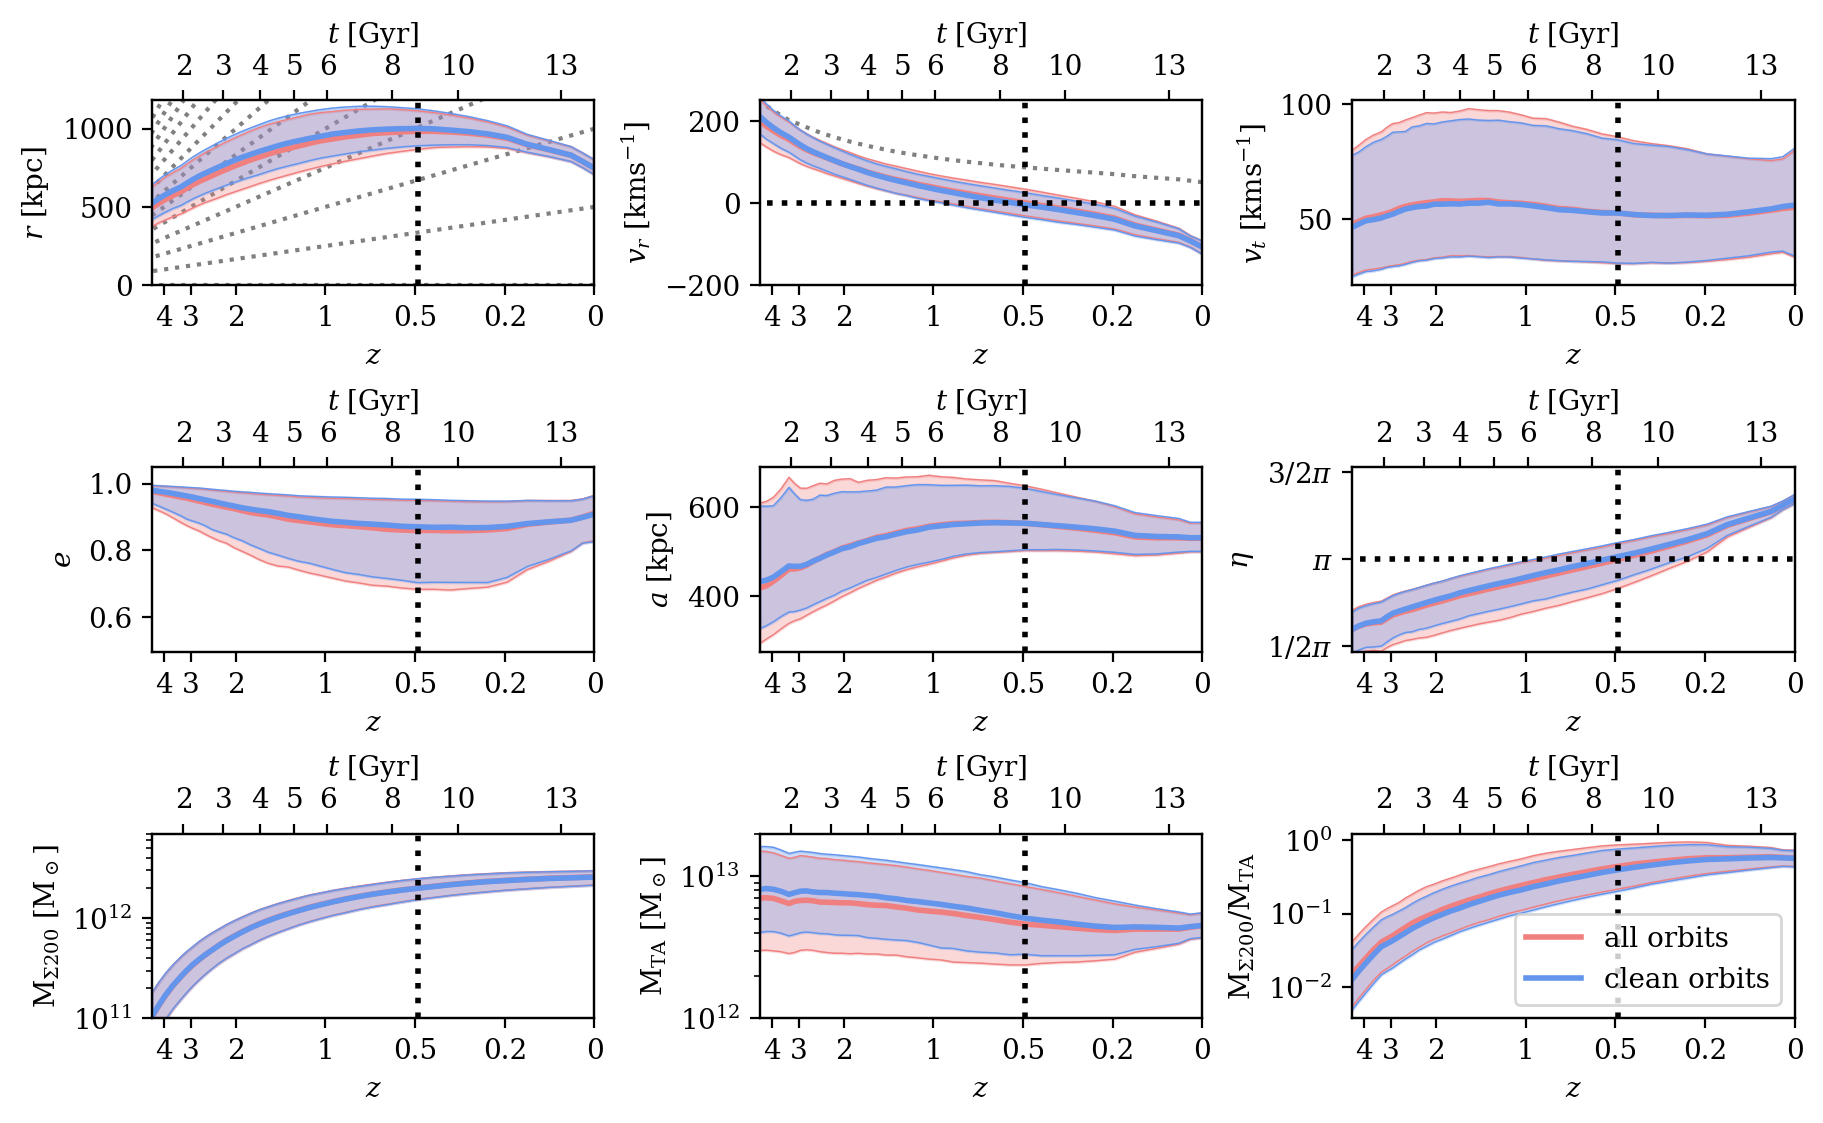

In [20]:
mask_strict = few_problems

list_M_TA_s = list_M_TA[mask_strict]
list_a_TA_s = list_a_TA[mask_strict]
list_e_TA_s = list_e_TA[mask_strict]
list_eta_TA_s = list_eta_TA[mask_strict]
list_solver_TA_s = list_solver_TA[mask_strict]
list_r_s = list_r[mask_strict]
list_vr_s = list_vr[mask_strict]
list_vt_s = list_vt[mask_strict]
list_M_MW_s = list_M_MW[mask_strict]
list_M_M31_s = list_M_M31[mask_strict]
list_N_prog_s = list_N_prog[mask_strict]
selection_orbits_s = mask_strict

list_M_TA_l = list_M_TA
list_a_TA_l = list_a_TA
list_e_TA_l = list_e_TA
list_eta_TA_l = list_eta_TA
list_solver_TA_l = list_solver_TA
list_r_l = list_r
list_vr_l = list_vr
list_vt_l = list_vt
list_M_MW_l = list_M_MW
list_M_M31_l = list_M_M31
list_N_prog_l = list_N_prog
selection_orbits_l = np.arange(len(list_M_TA))

# radii:

r_med = []
r_plus1 = []
r_minus1 = []


for idx, snap in enumerate(fine_index):
    r = np.array([list_r_s[i][idx] for i in range(len(selection_orbits_s))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
    
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
          
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_s[i][idx] + list_M_M31_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

# M by M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_s[i][idx] + list_M_M31_s[i][idx]) / list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))

# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_s = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_s = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_s = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# LOOSE


# radii:

r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    
    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))

# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
             
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_l[i][idx] + list_M_M31_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

#M / M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_l[i][idx] + list_M_M31_l[i][idx]) / list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))
    
# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_l = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_l = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_l = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# plotting
        
fig, axes = plt.subplots(figsize=(9,5.5), ncols=3, nrows=3, dpi=200, constrained_layout = True)
norm = plt.Normalize(0,1)


for i, ax in enumerate(fig.axes):
    
    ax.fill_between(scale[fine_index], var_minus1_l[i], var_plus1_l[i], color='lightcoral', alpha=.3)
    ax.fill_between(scale[fine_index], var_minus1_s[i], var_plus1_s[i], color='cornflowerblue', alpha=.3)
    
    ax.plot(scale[fine_index], var_med_l[i], c='lightcoral', lw=2., ls='solid', zorder=2, label = 'all orbits')
    ax.plot(scale[fine_index], var_plus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)

    ax.plot(scale[fine_index], var_med_s[i], c='cornflowerblue', lw=2., ls='solid', zorder=2, label = 'clean orbits')
    ax.plot(scale[fine_index], var_plus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)

# Format and label the axes

for i, ax in enumerate(fig.axes):
        
    ax.axvline(scale[10], ls='dotted', c='black', lw=2)

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny() # ax1 and ax2 share y-axis
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
    ax.set_xlim(min(scale[fine_index]),1)
    ax2.set_xlim(min(scale[fine_index]),1)

axes[0,1].plot([0,1],[0,0], ls='dotted', c='black', lw=2)

axes[0,0].set_ylim(bottom=0)
axes[2,0].set_ylim(bottom = 1e11, top=7e12)
axes[2,1].set_ylim(bottom = 1e12, top=2e13)

axes[0,0].set_ylabel(r'$r \ [\mathrm{kpc}]$')
axes[0,1].set_ylabel(r'$v_r \ [\mathrm{kms^{-1}}]$')
axes[0,2].set_ylabel(r'$v_t \ [\mathrm{kms^{-1}}]$')

axes[1,0].set_ylabel(r'$e$')
axes[1,1].set_ylabel(r'$a  \ [\mathrm{kpc}]$')
axes[1,2].set_ylabel(r'$\eta$')

axes[2,0].set_ylabel(r'$\mathrm{M_{\Sigma 200} \ [M_\odot]}$')
axes[2,1].set_ylabel(r'$\mathrm{M_{TA} \ [M_\odot]}$')
axes[2,2].set_ylabel(r'$\mathrm{M_{\Sigma 200} / M_{TA}}$')

axes[2,0].set_yscale('log')
axes[2,1].set_yscale('log')
axes[2,2].set_yscale('log')
axes[2,2].minorticks_off()


ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# units of pi
axes[1,2].plot([0,1],[3.1415,3.1415], ls='dotted', c='black', lw=2)

axes[1,2].set_yticks(np.arange(0, 2*np.pi+0.01, np.pi/2))
#Change axis labels:
labels = ['$0$', r'$1/2 \pi$', r'$\pi$', r'$3/2\pi$', r'$2\pi$']
axes[1,2].set_yticklabels(labels)
axes[1,2].set_ylim(np.pi / 2 - .1, 3*np.pi / 2 + .1)

axes[0,2].autoscale_view(True,True,True)

# overplot expansion of the universe:
for i in range (50):
    axes[0,0].plot(scale, i*500*scale, c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)
    
# for the hubble expansion speed, we use the median separation
    
Hubble_flow = cosmo.H(1/scale - 1).value # value is km/s / Mpc
axes[0,1].plot(scale[fine_index], Hubble_flow[fine_index] * r_med / 1000., c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)

axes[0,1].set_ylim(-200,250)
axes[1,0].set_ylim(0.495,1.05)

axes[2,2].legend()

plt.savefig('evolution_problems.pdf')

In [21]:
# Make a 2D-Matrix (1 line for each MW/M31 analogue, 1 column for each snapshot)
# It's an array of array where np.vstack changes that in lines [[...],[...]] => [[...] 
#                                                                                [...]]

m_MW = np.vstack([np.array(list_M_MW_l[i])[fine_index] for i in range(len(selection_orbits_l))])
m_M31 = np.vstack([np.array(list_M_M31_l[i])[fine_index] for i in range(len(selection_orbits_l))])

# Find the indix corresponding to z = 0 (i.e. a = 1) to find the current mass
idx_z0 = np.argmin(np.abs(scale[fine_index] - 1.0))

# Normalise for each MW/M31 analogue by its own final mass
m_MW_norm  = m_MW  / m_MW[:, idx_z0][:, None]
m_M31_norm = m_M31 / m_M31[:, idx_z0][:, None]

# Computing stastistical datas (med, sigma)
def stats(arr):
    return (np.percentile(arr, 50, axis=0), np.percentile(arr, 84, axis=0), np.percentile(arr, 16, axis=0))

m_MW_med, m_MW_plus1, m_MW_minus1 = stats(m_MW)
m_M31_med, m_M31_plus1, m_M31_minus1 = stats(m_M31)

m_MW_med_norm, m_MW_plus1_norm, m_MW_minus1_norm = stats(m_MW_norm)
m_M31_med_norm, m_M31_plus1_norm, m_M31_minus1_norm = stats(m_M31_norm)

print("Computation done.")

Computation done.


## Ploting MW and M31 mass evolution

### We first compute everything needed for the following plots - with and without normalisation

In [22]:
np.savez(
    "MW_M31_in_LG_mass_stats.npz",
    scale=scale[fine_index],

    m_MW=m_MW,
    m_M31=m_M31,
    m_MW_norm=m_MW_norm,
    m_M31_norm=m_M31_norm,

    m_MW_med=m_MW_med,
    m_MW_plus1=m_MW_plus1,
    m_MW_minus1=m_MW_minus1,
    m_MW_med_norm=m_MW_med_norm,
    m_MW_plus1_norm=m_MW_plus1_norm,
    m_MW_minus1_norm=m_MW_minus1_norm,

    m_M31_med=m_M31_med,
    m_M31_plus1=m_M31_plus1,
    m_M31_minus1=m_M31_minus1,
    m_M31_med_norm=m_M31_med_norm,
    m_M31_plus1_norm=m_M31_plus1_norm,
    m_M31_minus1_norm=m_M31_minus1_norm,
)

print("Data saved.")

Data saved.


### We plot the MW and M31 mass evolution without normalisation on two separated graphs

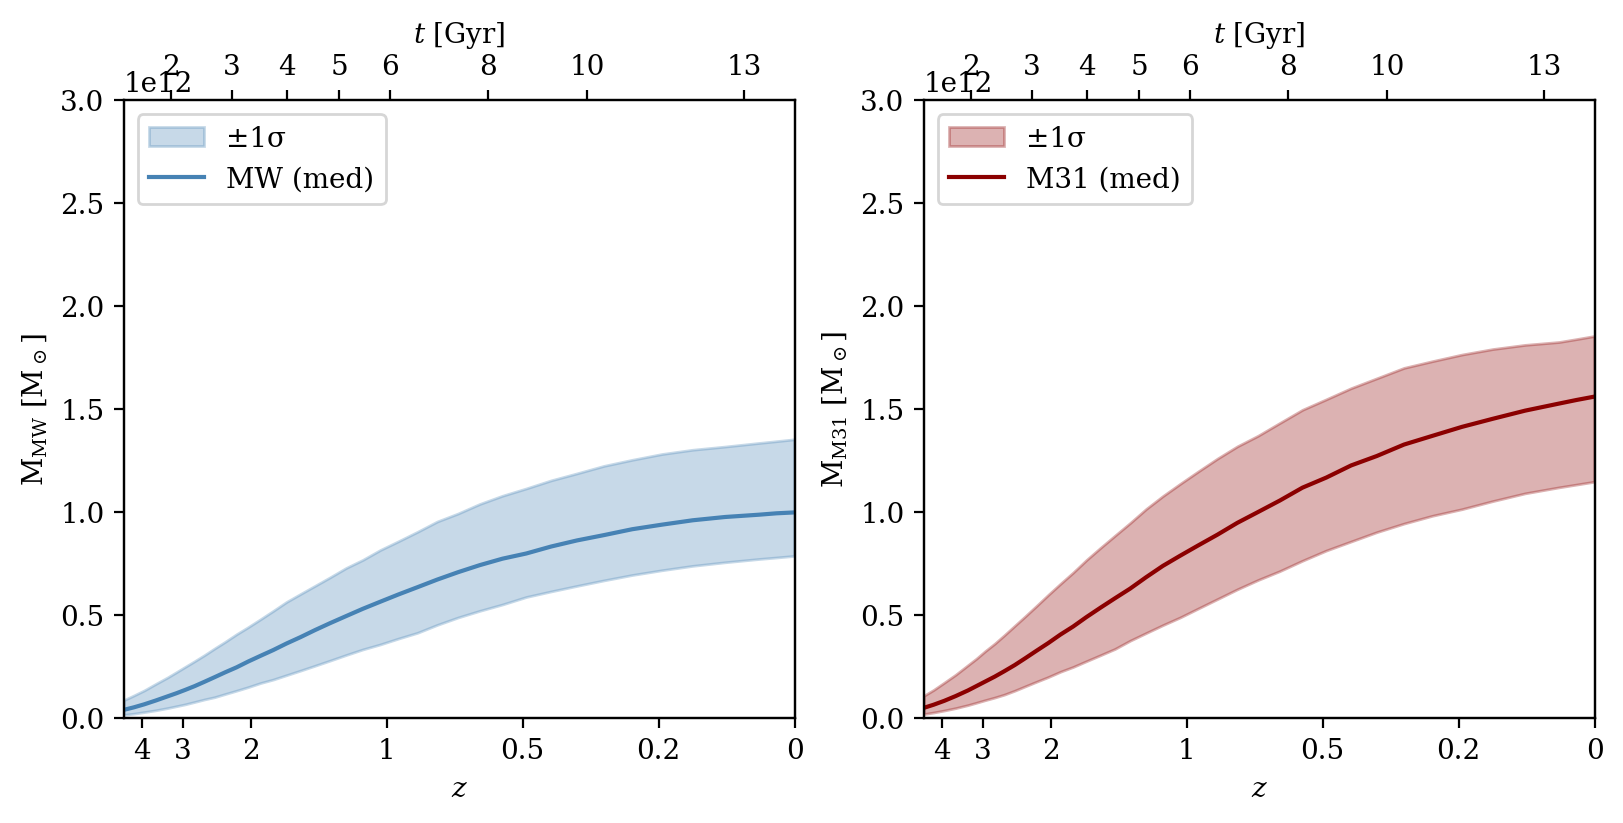

In [23]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1, m_MW_plus1, color='steelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med, color='steelblue', lw=1.5, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='darkred', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med, color='darkred', lw=1.5, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 3e12)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 3e12)

axes[0].set_ylabel(r'$\mathrm{M_{MW} \ [M_\odot]}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31} \ [M_\odot]}$')



# Save plot
plt.savefig('MW_M31_LG_2_plots_evolution_mass.png')
plt.show()

### Same plot with normalisation

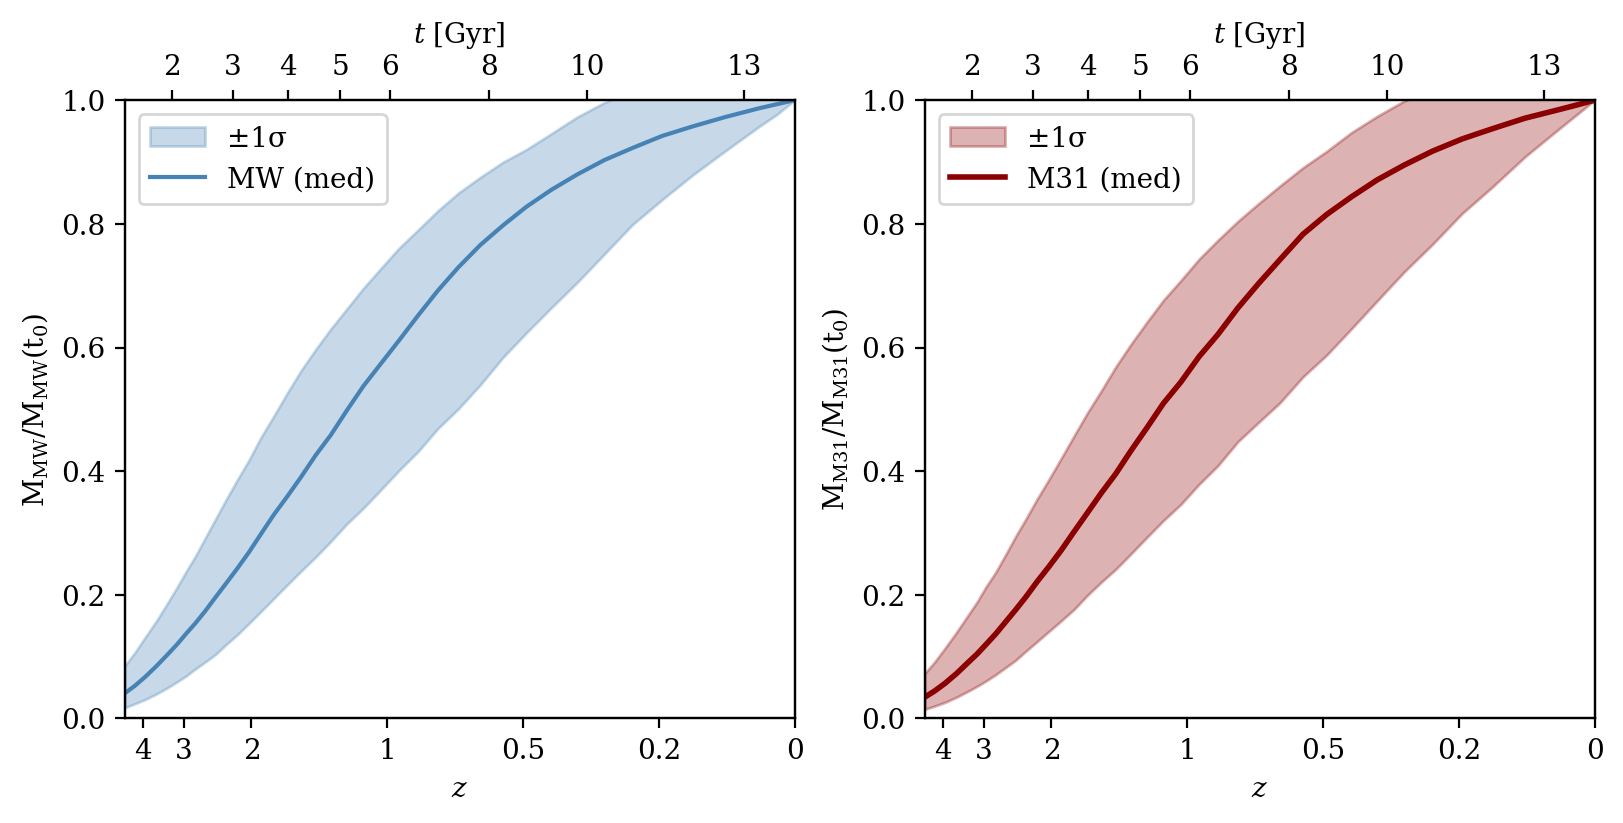

In [29]:
'''
# Normalisation factors are different for MW and M31
norm_MW = m_MW_med[idx_z0]
norm_M31 = m_M31_med[idx_z0]

# Mormalisation
m_MW_med_norm = m_MW_med / norm_MW
m_MW_plus1_norm = m_MW_plus1 / norm_MW
m_MW_minus1_norm = m_MW_minus1 / norm_MW

m_M31_med_norm = m_M31_med / norm_M31
m_M31_plus1_norm = m_M31_plus1 / norm_M31
m_M31_minus1_norm = m_M31_minus1 / norm_M31'''


# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='steelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med_norm, color='steelblue', lw=1.5, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='darkred', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med_norm, color='darkred', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 1)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 1)

axes[0].set_ylabel(r'$\mathrm{M_{MW}/M_{MW}(t_0)}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31}/M_{M31}(t_0)}$')


# Save plot
plt.savefig('MW_M31_LG_2_plots_normalised_evolution_mass.png')
plt.show()

### We superpose the two plots without normalisation

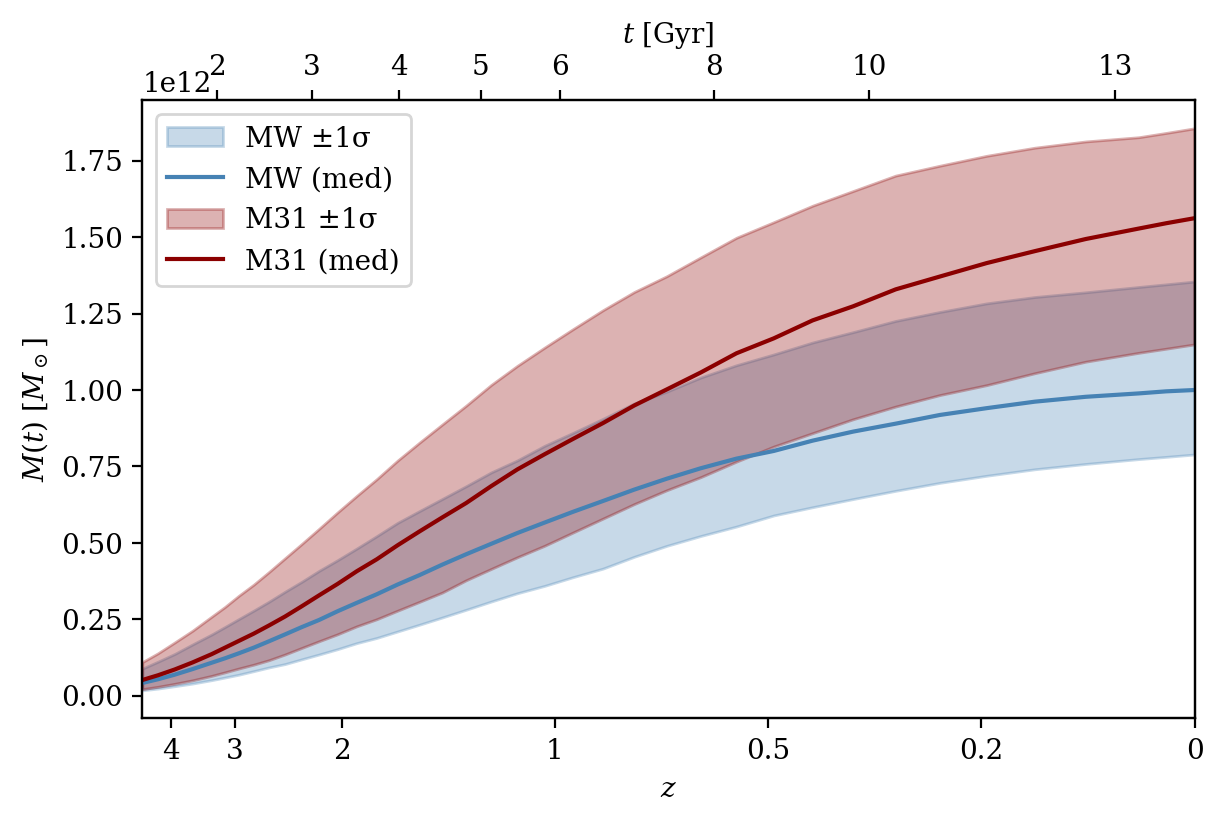

In [30]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

# Tracé pour la Voie Lactée (MW)
ax.fill_between(scale[fine_index],
                m_MW_minus1, m_MW_plus1,
                color='steelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index], m_MW_med, color='steelblue', lw=1.5, label='MW (med)')

# Tracé pour M31
ax.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='darkred', alpha=0.3, label='M31 ±1σ')
ax.plot(scale[fine_index], m_M31_med, color='darkred', lw=1.5, label='M31 (med)')

ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

ax.set_ylabel(r'$M(t)\ [M_\odot]$')

ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

ax.legend(loc='upper left')
plt.savefig('MW_M31_LG_superposed_evolution_mass.png')
plt.show()


### Same plot with normalisation

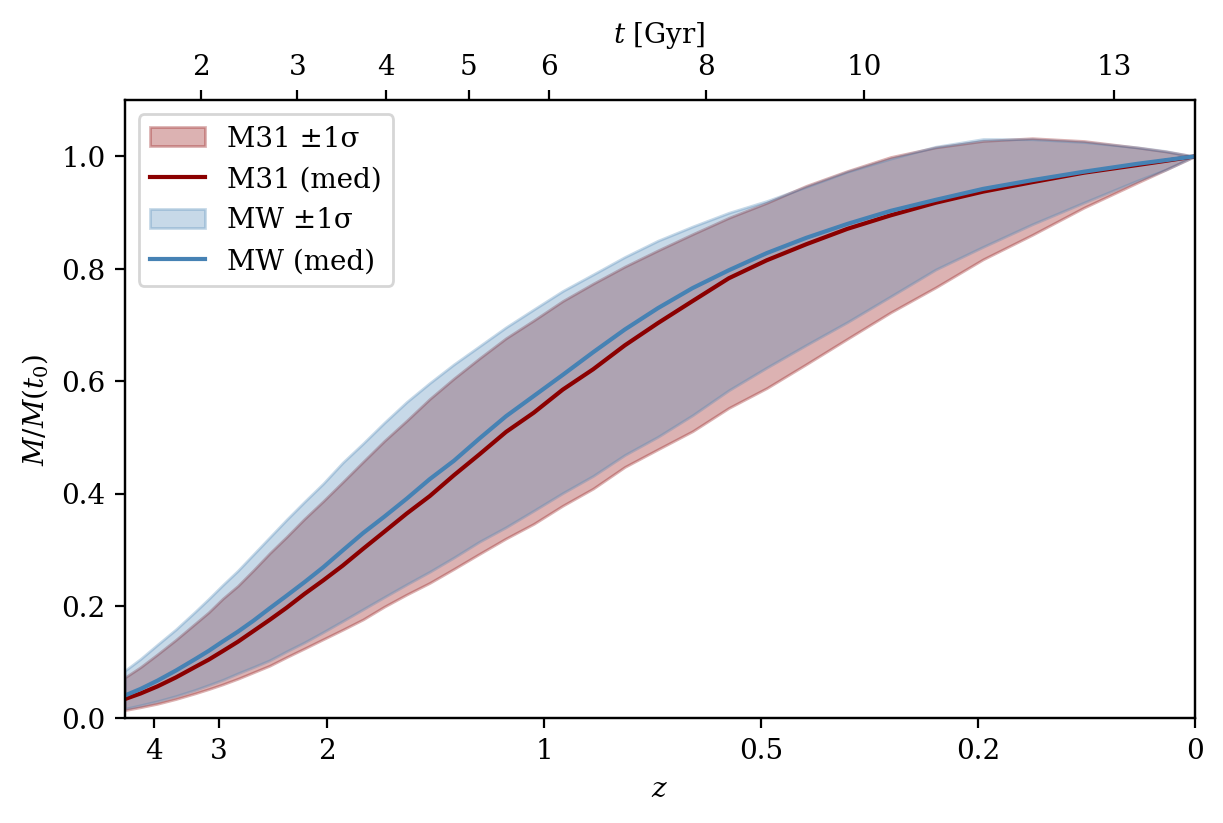

In [32]:
# Ploting

fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

ax.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='darkred', alpha=0.3, label='M31 ±1σ')
ax.plot(scale[fine_index], m_M31_med_norm, color='darkred', lw=1.5, label='M31 (med)')

ax.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='steelblue', alpha=0.3, label='MW ±1σ')
ax.plot(scale[fine_index], m_MW_med_norm, color='steelblue', lw=1.5, label='MW (med)')

#------------
# Axes
#------------

# Redshift
ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

# Time in Gyr
ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

# Normalised mass
ax.set_ylim(0, 1.1)
ax.set_ylabel(r'$M/M(t_0)$')

# Legend
ax.legend(loc='upper left')


plt.savefig('MW_M31_LG_superposed_normalised_evolution_mass.png')
plt.show()
